In [ ]:
import os

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
analyze_path = os.path.join(parent_dir, "utils")

os.chdir(analyze_path)

要先建立輸入到模型的資料
- 若是要分類是否是熱點，應該要以一個區域的grid為單位
- 所以建立得grid亦包含該地區的所有特徵資料，以比例顯示

In [46]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
# plt.rcParams['font.family'] = ['Arial Unicode Ms']
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']

from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from utils_model import eval_loop, to_tensors

In [ ]:
from utils import read_data
combined_data = read_data()

## obtain hotspot's county
這段使用將grid依照geometry找出個別在哪個城市

In [ ]:
from shapely import wkt
import geopandas as gpd
import ast

TM2 = 3826
taiwan = gpd.read_file('../Data/OFiles_9e222fea-bafb-4436-9b17-10921abc6ef2/TOWN_MOI_1140318.shp')
taiwan = taiwan[(~taiwan['TOWNNAME'].isin(['旗津區', '頭城鎮', '蘭嶼鄉', '綠島鄉', '琉球鄉'])) & 
                (~taiwan['COUNTYNAME'].isin(['金門縣', '連江縣', '澎湖縣']))].to_crs(TM2)
taiwan_cnty = taiwan[['COUNTYNAME','geometry']].dissolve(by='COUNTYNAME')
taiwan_cnty['geometry'] = taiwan_cnty.buffer(0)

# 原始以 0.001 grid 計算出的區域事故及對應索引, 依照 hex_grid 計算出來的GI
grid_gi_df = pd.read_csv('../ComputedData/Grid/grid_gi.csv')
grid_gi_df['accident_indices'] = grid_gi_df['accident_indices'].apply(ast.literal_eval)
grid_gi_df['geometry'] = grid_gi_df['geometry'].apply(wkt.loads)
grid_gi  = gpd.GeoDataFrame(grid_gi_df, geometry='geometry').set_crs(TM2, allow_override=True)
grid_gi['geometry'] = grid_gi.geometry.centroid

county_join = gpd.sjoin(grid_gi[['geometry']], taiwan_cnty, how='left', predicate='within')
grid_gi['COUNTYNAME'] = county_join['COUNTYNAME']

# 這些都是離島資料，因為在taiwan被篩選掉了，所以會因為對應不到所以回傳空值
print('NaN ratio:', county_join['COUNTYNAME'].isna().mean())

# find all_features at DataPreprocess
grid_filter = grid_gi[grid_gi['accident_indices'].str.len() > 0].reset_index()
all_features_df = pd.read_csv("../ComputedData/ForModel/all_features.csv")

# 移除高共線

In [ ]:
cols = all_features_df.columns[all_features_df.columns.str.contains('事故位置大類別名稱')]
all_features_df.drop(columns=cols, inplace=True)

# Model Preprocess

In [ ]:
# with county town
# 原始資料index並非從1開始所以需reset
new_grid = pd.concat([grid_filter[['hotspot', 'COUNTYNAME']], all_features_df], axis=1)
county_dummies = pd.get_dummies(new_grid['COUNTYNAME'], prefix='county')
new_grid_encoded = pd.concat([new_grid.drop(['COUNTYNAME'], axis=1), county_dummies], axis=1)

# binary hotspot
new_grid_encoded['hotspot'] = new_grid_encoded['hotspot'].apply(lambda x: 'Hotspot' if 'Hotspot' in str(x) else 'Not Hotspot')

le = LabelEncoder()
y = le.fit_transform(new_grid_encoded['hotspot'])
X = new_grid_encoded.drop(columns=['hotspot'])

# interaction
from utils_model import get_interaction
X = get_interaction(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
y_train = pd.Series(y_train, index=X_train.index)
y_test  = pd.Series(y_test,  index=X_test.index)

# undersampling
cls_counts = y_test.value_counts()
min_count = cls_counts.min()
rus_test = RandomUnderSampler(
    sampling_strategy={int(c): int(min_count) for c in cls_counts.index},
    random_state=42
)
X_resampled_test, y_resampled_test = rus_test.fit_resample(X_test, y_test)

print("before US")
print(pd.Series(y_test).map(dict(enumerate(le.classes_))).value_counts())
print("after US")
print(pd.Series(y_resampled_test).map(dict(enumerate(le.classes_))).value_counts())

# LR and RF

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid_lr = {
    'penalty': ['elasticnet'],
    'solver': ['saga'],
    'l1_ratio': [0.1, 0.5, 0.9],
    'C': [0.01, 0.1, 1, 10]
}

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 2, 5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# lr = GridSearchCV(
#     LogisticRegression(
#         penalty='elasticnet', solver='saga',
#         class_weight='balanced', max_iter=1000, 
#         random_state=42, multi_class='multinomial'
#     ),
#     param_grid=param_grid_lr,
#     cv=cv,
#     scoring='roc_auc',
#     n_jobs=-1
# )
# rf = GridSearchCV(
#     RandomForestClassifier(
#         class_weight='balanced', random_state=42
#     ),
#     param_grid=param_grid_rf,
#     cv=cv,
#     scoring='roc_auc',
#     n_jobs=-1
# )

lr = LogisticRegression(
        penalty='elasticnet', solver='saga', l1_ratio=0.5,
        class_weight='balanced', max_iter=1000, 
        random_state=42, 
        multi_class='multinomial',
        n_jobs=-1
    )
rf = RandomForestClassifier(
        n_estimators=300, max_depth=None, min_samples_leaf=1,
        class_weight='balanced', n_jobs=-1, random_state=42,
    )

for name, clf in [('Logistic', lr), ('RandomForest', rf)]:
    scores = cross_val_score(clf, X_train, y_train, cv=cv, n_jobs=-1,
                            # scoring='roc_auc_ovr_weighted',
                            scoring='roc_auc'
                             )
    print(f'{name} CV ROC AUC: {scores.mean():.3f} ± {scores.std():.3f}')

lr.fit(X_train, y_train)
rf.fit(X_train, y_train)

proba_test_lr = lr.predict_proba(X_resampled_test)
proba_test_rf = rf.predict_proba(X_resampled_test)
y_pred_lr = np.argmax(proba_test_lr, axis=1)
y_pred_rf = np.argmax(proba_test_rf, axis=1)

In [ ]:
import joblib

joblib.dump(lr, '../ComputedData/ModelPerformance/lr_model.pkl')
joblib.dump(rf, '../ComputedData/ModelPerformance/rf_model.pkl')

# load model
lr = joblib.load('../ComputedData/ModelPerformance/lr_model.pkl')
rf = joblib.load('../ComputedData/ModelPerformance/rf_model.pkl')

proba_test_lr = lr.predict_proba(X_resampled_test)
proba_test_rf = rf.predict_proba(X_resampled_test)
y_pred_lr = np.argmax(proba_test_lr, axis=1)
y_pred_rf = np.argmax(proba_test_rf, axis=1)

In [ ]:
from utils_model import print_results

print_results(proba_test_lr, le.classes_, y_resampled_test)

設施平均：該地區的事故點附近平均會有幾個設施

### RandomForest Feature Importance & LinearRegression coefficient
- group的寫法可能還要再修

In [ ]:
from utils_model import get_importance

importance_rf, importance_grouped_rf = get_importance(rf, X_train, 'county')
importance_lr, importance_grouped_lr = get_importance(lr, X_train, 'county')

In [ ]:
def build_structured_county(importance):
    """
    importance: dict, 例如 {"特徵A x county_臺北市": [coef, OR], ...}
    """
    out = {}

    for name, v in importance.items():
        # 跳過純縣市 dummy，如 "county_臺北市"
        if name.startswith("county_") and " x county_" not in name:
            continue
        # 只處理有交互字樣的
        if " x county_" not in name:
            continue

        base, county_tag = name.split(" x county_", 1)  # base 特徵名、county_tag 縣市名（不含前綴）

        out.setdefault(county_tag, {})[base] = v[1]

    return out

structured_all = build_structured_county(importance_lr)
structured_all = pd.DataFrame(structured_all)

In [ ]:
odds_df = structured_all[['臺北市', '新北市', '臺中市', '高雄市', '臺東縣', '花蓮縣']]
odds_df.sort_values(by='臺北市', ascending=False)

## Odds Ratio

In [ ]:
plt.rcParams['font.family'] = ['Arial Unicode Ms']

df_long = odds_df.stack().reset_index()
df_long.columns = ['feature', 'county', 'value']

# 用 max|ln(OR)| 當排序依據，抓前 top_k 個以免圖太擁擠
# 用 OR 排序會忽略小於 1 的強負向特徵
top_k = 30
rank = (
    df_long.assign(abs_log=lambda d: np.abs(np.log(d['value'])))
           .groupby('feature')['abs_log'].max()
           .sort_values(ascending=False)
)
feat_sel = rank.head(top_k).index
plot_data = df_long[df_long['feature'].isin(feat_sel)]

features = plot_data['feature'].dropna().unique().tolist()
features = [f for f in rank.index if f in features]  # 用上面 rank 的順序
ypos = {f: i for i, f in enumerate(features)}

plt.figure(figsize=(14, max(6, 0.4*len(features))))
plt.axvline(1.0, linestyle='--', linewidth=1)
plt.axvline(1.5, linestyle='--', linewidth=1)
plt.axvline(0.5, linestyle='--', linewidth=1)
plt.axvline(2, linestyle='--', linewidth=1)

for county, d in plot_data.groupby('county'):
    y = [ypos[f] for f in d['feature']]
    plt.scatter(d['value'], y, s=20, label=county)

plt.yticks(range(len(features)), features)
plt.xlabel('Odds Ratio (OR)')
plt.ylabel('Feature')
plt.title('Counties effect per feature (x = OR)')
plt.legend(title='County', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Neural Network

In [43]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
INPUT_DIM = X_resampled_test.shape[1]
NUM_CLASSES = int(len(le.classes_))  # 類別 0/1

class BinaryMLP(nn.Module):
    def __init__(self, in_dim=INPUT_DIM, num_classes=NUM_CLASSES, drop=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 1024),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(64, num_classes)  # logits
        )
    def forward(self, x):
        return self.net(x)

In [44]:
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

X_train_t, y_train_t = to_tensors(X_train, y_train)
X_val_t, y_val_t = to_tensors(X_val_nn, y_val_nn)
X_test_t, y_test_t = to_tensors(X_resampled_test, y_resampled_test)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=256, shuffle=True, drop_last=False)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=512, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=512, shuffle=False)

model = BinaryMLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

best_val = -np.inf
patience = 5
wait = 0
epochs = 20

In [47]:
for epoch in range(1, epochs+1):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

    train_loss = total_loss / len(train_loader.dataset)
    val_metrics = eval_loop(model, val_loader, le)
    print(f'Epoch {epoch:02d}/{epochs} | loss {train_loss:.4f} | '
          f'val_acc {val_metrics["acc"]:.3f} | val_f1 {val_metrics["f1"]:.3f} | val_auc {val_metrics["auc"]:.3f}')

    score_for_early = val_metrics["auc"]  # 你也可用 f1
    if score_for_early > best_val:
        best_val = score_for_early
        wait = 0
        # torch.save(model.state_dict(), 'best_model.pt')
    else:
        wait += 1
        if wait >= patience:
            print('Early stopping.')
            break

Epoch 01/20 | loss 0.3728 | val_acc 0.832 | val_f1 0.881 | val_auc 0.894
Epoch 02/20 | loss 0.3658 | val_acc 0.842 | val_f1 0.891 | val_auc 0.899
Epoch 03/20 | loss 0.3611 | val_acc 0.847 | val_f1 0.894 | val_auc 0.903
Epoch 04/20 | loss 0.3547 | val_acc 0.848 | val_f1 0.896 | val_auc 0.907
Epoch 05/20 | loss 0.3487 | val_acc 0.853 | val_f1 0.901 | val_auc 0.912
Epoch 06/20 | loss 0.3404 | val_acc 0.859 | val_f1 0.903 | val_auc 0.918
Epoch 07/20 | loss 0.3353 | val_acc 0.861 | val_f1 0.903 | val_auc 0.920
Epoch 08/20 | loss 0.3265 | val_acc 0.863 | val_f1 0.906 | val_auc 0.925
Epoch 09/20 | loss 0.3190 | val_acc 0.865 | val_f1 0.906 | val_auc 0.928
Epoch 10/20 | loss 0.3138 | val_acc 0.868 | val_f1 0.908 | val_auc 0.932
Epoch 11/20 | loss 0.3059 | val_acc 0.874 | val_f1 0.913 | val_auc 0.936
Epoch 12/20 | loss 0.2998 | val_acc 0.877 | val_f1 0.916 | val_auc 0.940
Epoch 13/20 | loss 0.2918 | val_acc 0.874 | val_f1 0.914 | val_auc 0.941
Epoch 14/20 | loss 0.2874 | val_acc 0.883 | val_f1 

In [48]:
# model = BinaryMLP().to(device)
# model.load_state_dict(torch.load('../ComputedData/ModelPerformance/nn_model.pth'))

# test_metrics = eval_loop(model, test_loader, le)
# print(test_metrics['report'])

torch.save(model.state_dict(), '../ComputedData/ModelPerformance/nn_model.pth')

In [56]:
test_metrics = eval_loop(model, test_loader, le)

## Permutation

In [50]:
from utils_model import build_groups_from_prefix, build_groups_with_interactions, build_pair_interaction_groups, PI_ML, PI_NN

groups = build_groups_with_interactions(X_test.columns)

print('lr')
base_lr, perm_lr = PI_ML(lr, X_test, y_test, groups=groups, n_repeats=10)
print('rf') 
base_rf, perm_rf = PI_ML(rf, X_test, y_test, groups=groups, n_repeats=10)
print('nn')
base_nn, perm_nn = PI_NN(model, X_test, y_test, groups=groups, n_repeats=10)

lr


/Users/wangqiqian/opt/anaconda3/envs/ST-RTA/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/wangqiqian/opt/anaconda3/envs/ST-RTA/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/wangqiqian/opt/anaconda3/envs/ST-RTA/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/wangqiqian/opt/anaconda3/envs/ST-RTA/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/wangqiqian/opt/anaconda3/envs/ST-RTA/lib/python3.9/site-packages/sklearn/utils/validation

rf


/Users/wangqiqian/opt/anaconda3/envs/ST-RTA/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/wangqiqian/opt/anaconda3/envs/ST-RTA/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/wangqiqian/opt/anaconda3/envs/ST-RTA/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/wangqiqian/opt/anaconda3/envs/ST-RTA/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/wangqiqian/opt/anaconda3/envs/ST-RTA/lib/python3.9/site-packages/sklearn/

nn


In [52]:
perm_lr.to_csv('../ComputedData/Permutation/perm_lr.csv')
perm_rf.to_csv('../ComputedData/Permutation/perm_rf.csv')
perm_nn.to_csv('../ComputedData/Permutation/perm_nn.csv')

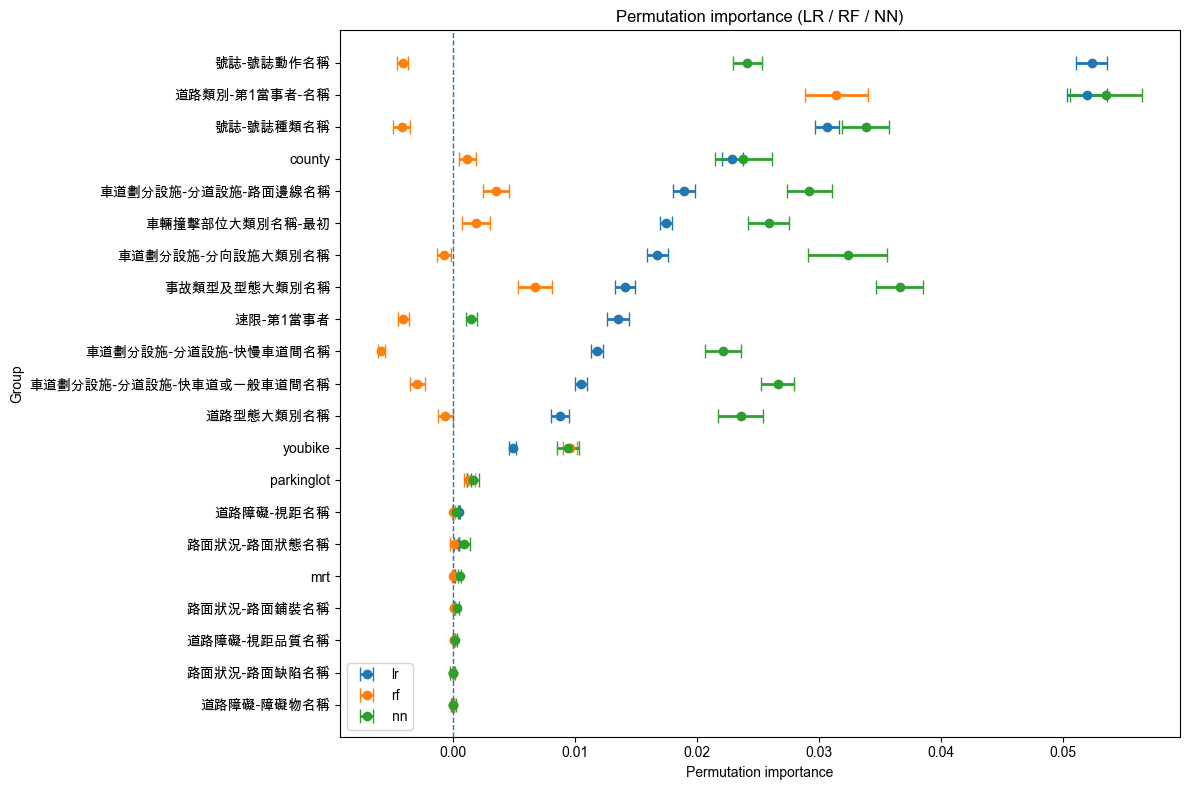

In [53]:
combined = pd.concat([
    perm_lr.assign(model='LR'),
    # perm_rf.assign(model='RF'),
    # perm_nn.assign(model='NN')
], ignore_index=True)

order = (combined.groupby('group')['importance'].mean().sort_values(ascending=True).index.tolist())
ypos = np.arange(len(order))

triples = [
    (perm_lr, 'lr'), 
    (perm_rf, 'rf'), 
    (perm_nn, 'nn')
    ]

plt.figure(figsize=(12, 8))

for perm_df_i, name in triples:
    d = (perm_df_i.set_index('group').reindex(order)) # 用統一群組順序對齊
    plt.errorbar(
        d['importance'],
        (ypos),
        xerr=d['std'],
        fmt='o',
        linewidth=2,
        capsize=5,
        label=name
    )

plt.yticks(ypos, order)
plt.axvline(0.0, linestyle='--', linewidth=1)
plt.xlabel('Permutation importance')
plt.ylabel('Group')
plt.title('Permutation importance (LR / RF / NN)')
plt.legend()
plt.tight_layout()
plt.show()


# Hitrate
le的轉換是1為not hotspot

In [54]:
county_cols = [col for col in X_resampled_test.columns if col.startswith('county_')]


df_hitrate = X_resampled_test.copy()
df_hitrate['y_true'] = y_resampled_test
df_hitrate['y_pred'] = y_pred_lr

hitrate = {}
for col in county_cols:

    mask = df_hitrate[df_hitrate[col] != False]
    tn, fp, fn, tp = confusion_matrix(
        mask['y_true'], mask['y_pred'], labels=[1, 0] # 這裡0是Hotspot
    ).ravel()

    # calculate precision, recall, accuracy, f1-score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    hitrate[col] = {
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy,
        'f1': f1
    }

hitrate_df = pd.DataFrame.from_dict(hitrate, orient='index', columns=['precision', 'recall', 'accuracy', 'f1']).sort_values('f1', ascending=False)
hitrate_df['county'] = hitrate_df.index
hitrate_df['county'] = hitrate_df['county'].str.replace('county_', '')

In [57]:
from utils_model import hitrate_data

hitrate_lr = hitrate_data(X_resampled_test, y_resampled_test, y_pred_lr)
hitrate_rf = hitrate_data(X_resampled_test, y_resampled_test, y_pred_rf)
hitrate_nn = hitrate_data(X_resampled_test, y_resampled_test, test_metrics['pred_y'])

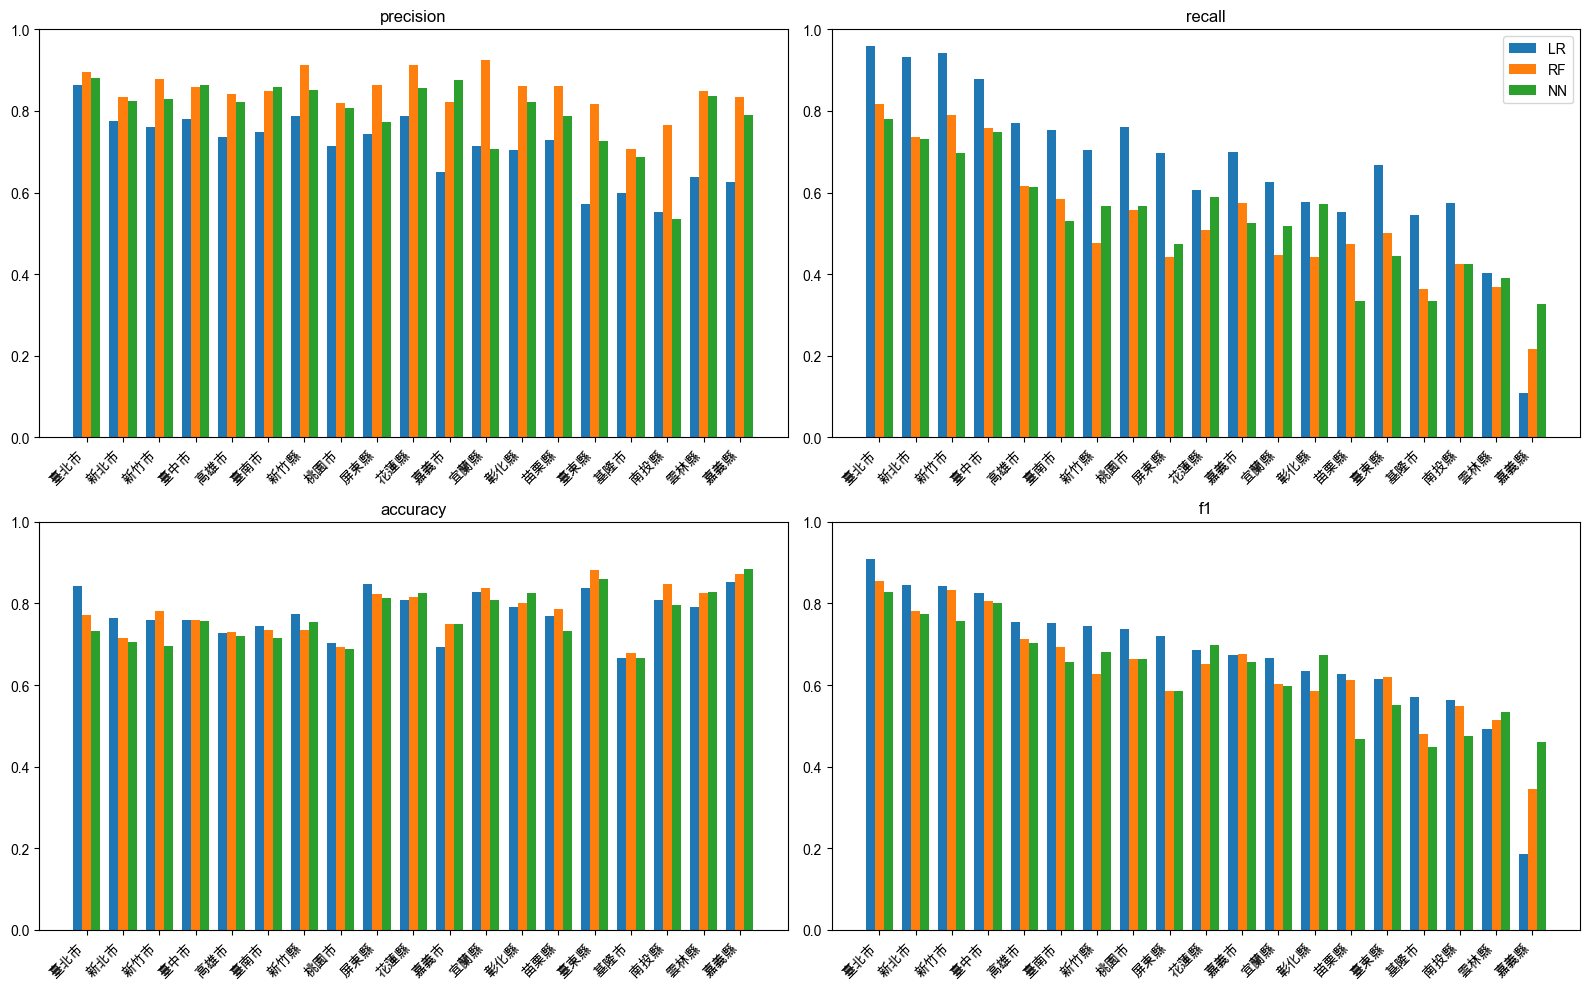

In [58]:
results = {
    'LR': hitrate_lr.copy(),
    'RF': hitrate_rf.copy(),
    'NN': hitrate_nn.copy(),
}
order = (results['LR'].sort_values('f1', ascending=False)['county']).tolist()

metrics = ['precision', 'recall', 'accuracy', 'f1']
plt.figure(figsize=(16, 10))

for i, met in enumerate(metrics, 1):
    ax = plt.subplot(2, 2, i)
    pos = np.arange(len(order))
    width = 0.25
    for j, (name, df) in enumerate(results.items()):
        d = df.set_index('county').reindex(order)
        ax.bar(pos + (j-1)*width, d[met].values, width=width, label=name)
    ax.set_title(met)
    ax.set_xticks(pos)
    ax.set_xticklabels(order, rotation=45, ha='right')
    if i == 2:
        ax.legend(loc='upper right')
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()


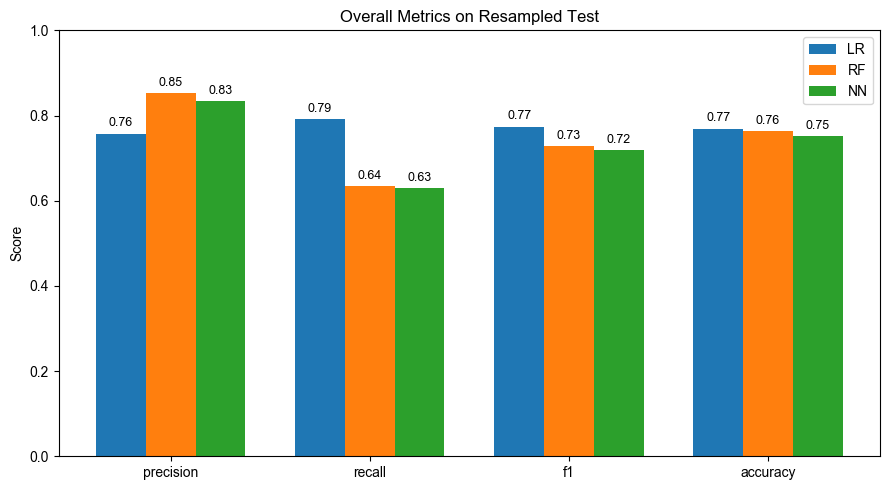

In [59]:
def metrics_bin(y_true, y_pred):
    return {
        'precision': precision_score(y_true, y_pred, pos_label=0),
        'recall':    recall_score(y_true, y_pred, pos_label=0),
        'f1':        f1_score(y_true, y_pred, pos_label=0),
        'accuracy':  accuracy_score(y_true, y_pred),
    }

m_lr = metrics_bin(y_resampled_test, y_pred_lr)
m_rf = metrics_bin(y_resampled_test, y_pred_rf)
m_nn = metrics_bin(y_resampled_test, test_metrics['pred_y'])

df = pd.DataFrame([m_lr, m_rf, m_nn], index=['LR','RF','NN'])
metrics = ['precision', 'recall', 'f1', 'accuracy']
df = df[metrics]

plt.figure(figsize=(9, 5))
x = np.arange(len(metrics))
width = 0.25

for i, model in enumerate(df.index):
    plt.bar(x + (i-1)*width, df.loc[model].values, width=width, label=model)

plt.xticks(x, metrics)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Overall Metrics on Resampled Test')
plt.legend(loc='upper right')

for i, model in enumerate(df.index):
    vals = df.loc[model].values
    for xi, v in zip(x + (i-1)*width, vals):
        plt.text(xi, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()